# **<font color='crimson'>«ТУРНИКЕТЫ»</font>**

---


**Выполнил:** Егор Юмаев

# **<font color='green'>ВВЕДЕНИЕ</font>**

---

Для объекта, допуск на территорию которого возможен только через систему пропуска, собраны данные о времени пересечения держателями пропуска контрольных точек:

 * пересечение парковки через шлагбаум;

 * проход по пропуску на соответствующий этаж здания.



**Цель**: на основе накопленных данных идентифицировать посетителя в зависимости от характерного времени его прохода на территорию организации, исключив вероятность передачи пропуска одним сотрудником другому. Таким образом необходимо исключить ситуации, когда один сотрудник прикладывает пропуск за другого, который даже не появляется в организации, но по цифровому следу присуствует на ее территории.

Для достижения цели выполнены следующие **задачи**:

* проведен исследовательский анализ данных, выявлены характерные особенности, удалены выбросы и дубликаты;

* с помощью Feature Engineering на основе признака 'ts' с информацией о дате и времени пересечения турникета сгенерировано 80 новых обучающих признаков. После проверки на мультиколлинеарность удалены 3 признака;

* обучены модели LogisticRegression и CatBoost. Лучший результат получен на модели CatBoost, обученной с гиперпараметром loss_function = 'MultiClassOneVsAll'.


Преимущественно датасет включает информацию о посетителях, которые ранее неоднократно бывали в организации. Однако, могут присутствовать сведения о новых посетителях (оценочно - таких не более 10% от всех посетителей).

В исходных данных id посетителя заменены на слова.

**Метрика**, отражающая качество обученной модели, может быть выбрана произвольно.

В техзадании на выполнение проекта оговорено **ограничение**: машинное обучение должно быть выполнено отдельно для:

- линейной (логистической) регрессии

- модели, основанной на решающем дереве

Решаемая в рамках проекта задача является задачей **мультиклассификации**.

## **<font color='green'>1 ПРОВЕДЕНИЕ ОБЗОРА ДАННЫХ (EDA)</font>**

---


In [1]:
# устанавливаем библиотеку catboost, модель из которой
# потребуется для машинного обучения
!pip install -q catboost

In [2]:
# импорт необходимых библиотек

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import (
    date,
    datetime)
from dateutil import relativedelta
from tqdm.notebook import tqdm
tqdm.pandas()

# подготовка к машинному обучению
from sklearn.preprocessing import (
    MinMaxScaler,
    PolynomialFeatures)
from sklearn.feature_selection import (
    SelectKBest,
    f_regression,
    chi2)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold)
from sklearn import set_config
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imb_pipeline
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector as selector)

# модель машинного обучения
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay)

# визуализация списка преобразований (шагов)
set_config(display="diagram")

# убираем 'красные' предупреждения
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 1

In [3]:
# загружаем zip-архив с датасетами
! gdown 1-UkWwmStmUN9LftkimdKQ2CmYP-n3RDt

# разархивируем загруженный архив
! unzip -o /content/2023-ods-turnstiles-linear.zip

# сохраняем датасеты в переменные
train = pd.read_csv('/content/2023-ods-turnstiles-linear/train.csv', index_col = 0)
test = pd.read_csv('/content/2023-ods-turnstiles-linear/test.csv', index_col = 0)
submit_exemple = pd.read_csv('/content/2023-ods-turnstiles-linear/sample_submit.csv')

print('Datasets load from Google Drive storage')

Downloading...
From: https://drive.google.com/uc?id=1-UkWwmStmUN9LftkimdKQ2CmYP-n3RDt
To: /content/2023-ods-turnstiles-linear.zip
100% 281k/281k [00:00<00:00, 79.1MB/s]
Archive:  /content/2023-ods-turnstiles-linear.zip
  inflating: 2023-ods-turnstiles-linear/sample_submit.csv  
  inflating: 2023-ods-turnstiles-linear/test.csv  
  inflating: 2023-ods-turnstiles-linear/train.csv  
Datasets load from Google Drive storage


In [4]:
# выведем последние пять строк датасета train
train.tail()

,user_id,ts,gate_id
37513,6,2022-12-31 20:38:56,11
37514,6,2022-12-31 20:39:22,6
37515,6,2022-12-31 20:39:23,6
37516,6,2022-12-31 20:39:31,9
37517,6,2022-12-31 20:39:31,9


In [5]:
# выведем первые пять строк датасета test
test.head()

,ts,gate_id,user_word
37518,2023-01-03 08:21:00,9,gini
37519,2023-01-03 08:21:00,9,gini
37520,2023-01-03 08:21:18,5,gini
37521,2023-01-03 08:21:19,5,gini
37522,2023-01-03 08:21:39,10,gini


In [6]:
# выведем информацию о размере датасетов
train.shape, test.shape

((37518, 3), (7125, 3))

In [7]:
# проверим тип данных в столбцах
train.dtypes

user_id     int64
ts         object
gate_id     int64
dtype: object

In [8]:
test.dtypes

ts           object
gate_id       int64
user_word    object
dtype: object

Тип данных необходимо изменить для признака 'ts' обоих датасетов. Признак содержит информацию о времени пересечения точки контроля.

In [9]:
# меняем тип данных с object на datetime
train['ts'] = pd.to_datetime(
    train['ts'],
    format = '%Y-%m-%d %H:%M:%S')

test['ts'] = pd.to_datetime(
    test['ts'],
    format = '%Y-%m-%d %H:%M:%S')

In [10]:
# проверяем изменение типа данных
train.dtypes

user_id             int64
ts         datetime64[ns]
gate_id             int64
dtype: object

In [11]:
test.dtypes

ts           datetime64[ns]
gate_id               int64
user_word            object
dtype: object

In [12]:
# проверим, расположены ли даты в хронологическом порядке
(
    train['ts'].is_monotonic_increasing,
    test['ts'].is_monotonic_increasing
)

(True, True)

Фиксация прохождения контрольных пунктов собрана в датасете в хронологическом порядке. Это особенно важно по той причине, что для обучения модели помимо признака **'gate_id'** (идентификационный номер пункта пропуска) есть только дата, на основе которой потребуется создать обучающие признаки для модели.

In [13]:
# выведем сведения о самой ранней и поздней дате наблюдения
# по датасету train
print(f'Самая ранняя дата наблюдений: {train.ts.min()}')
print(f'Самая поздняя дата наблюдений: {train.ts.max()}')

Самая ранняя дата наблюдений: 2022-07-29 09:08:54
Самая поздняя дата наблюдений: 2022-12-31 20:39:31


In [14]:
# вычислим длительность наблюдений по датасету train
date_min = datetime.strptime("29/07/2022", "%d/%m/%Y")
date_max = datetime.strptime("31/12/2022", "%d/%m/%Y")
difference = (relativedelta.relativedelta(date_max, date_min))
print('Число дней наблюдения по датасету train')
print(difference.months, 'months', difference.days, 'days')

Число дней наблюдения по датасету train
5 months 2 days


Аналогично рассчитаем дату начала и завершения наблюдений из датасета test и общую длительность в месяцах и днях.

In [15]:
# выведем сведения о самой ранней и поздней дате наблюдения
# по датасету test
print(f'Самая ранняя дата наблюдений: {test.ts.min()}')
print(f'Самая поздняя дата наблюдений: {test.ts.max()}')

Самая ранняя дата наблюдений: 2023-01-03 08:21:00
Самая поздняя дата наблюдений: 2023-02-24 19:44:09


In [16]:
# вычислим длительность наблюдений по датасету test
date_min = datetime.strptime("03/01/2023", "%d/%m/%Y")
date_max = datetime.strptime("24/02/2023", "%d/%m/%Y")
difference = (relativedelta.relativedelta(date_max, date_min))
print('Число дней наблюдения по датасету test')
print(difference.months, 'months', difference.days, 'days')

Число дней наблюдения по датасету test
1 months 21 days


Вычислим количество пунктов пропуска в датасетах train и test. Суммарно их будет больше в датасете train, превосходящем датасет test по количеству наблюдений более чем в пять раз. Важнее сопоставить, что все уникальные id пропускных пунктов фигурируют в обоих датасетах.

In [17]:
# вычислим уникальные id пунктов пропуска в датасете train и
# количество пересечений каждого пункта
train_gate = train['gate_id'].value_counts(dropna = False).sort_index()
train_gate

-1       48
 0        2
 1        5
 3     5351
 4     8170
 5     4619
 6     1800
 7     3026
 8       48
 9     3390
 10    4767
 11    4090
 12     698
 13    1201
 14       1
 15     298
 16       4
Name: gate_id, dtype: int64

In [18]:
# вычислим уникальные id пунктов пропуска в датасете test и
# количество пересечений каждого пункта
test_gate = test['gate_id'].value_counts(dropna = False).sort_index()
test_gate

-1        2
 1        2
 2        4
 3      909
 4     1459
 5      860
 6      294
 7      540
 8       18
 9      780
 10     915
 11     762
 12     132
 13     345
 14       1
 15     102
Name: gate_id, dtype: int64

Определим пункты пропуска, которые есть в train, но которых нет в test.

In [19]:
# выявим, каких id пунктов пропуска из train нет в test
gate_only_in_train = ~np.isin(train_gate.index, test_gate.index)
train_gate[gate_only_in_train].index

Int64Index([0, 16], dtype='int64')

В датасете test отсутствуют записи о пунктах пропуска с id 0 и 16, которые есть в датасете train.

Определим пункты пропуска, которые есть в test, но которых нет в train.

In [20]:
# выявим, каких id пунктов пропуска из test нет в train
gate_only_in_test = ~np.isin(test_gate.index, train_gate.index)
test_gate[gate_only_in_test].index

Int64Index([2], dtype='int64')

В датасете train отсутствуют записи о пунктах пропуска с id 2, которые есть в датасете test.

По пунктам пропуска 0, 2, 16 отмечается предельно низкое количество пересечений в сравнении с большинством пунктов пропуска.

Подавляющая часть пропускных пунктов представлена в обоих датасетах. Некоторые пункты пропуска отличаются крайне незначительным количеством пересечений. Вероятно, они ведут в помещения, которые в силу различных причин редко посещаются.

По пунктам пропуска с id 0, 1, 2, 14, 16 по обоим датасетам train и test наблюдается или крайне низкое, или нулевое число пересечений. Предполагаем, что их пересечение идет вразрез с типичным 'портретом' пересекающего пропускной пункт посетителя, поэтому соответствующие наблюдения для обоих датасетов можно удалить.

По пункту gate_id -1 отмечается всего два пересечения в датасете test, но целых 48 пересечений в датасете train. Для машинного обучения получаем ситуацию, когда модель будет изучать закономерности для пропуска с id -1, а в тестовых данных его не будет. Поэтому наблюдения для gate_id -1 тоже удалим.

In [21]:
# создадим список с id пропускных пунктов на удаление
list_gate_id_del = [-1, 0, 1, 2, 14, 16]

In [22]:
# создадим функцию для удаления наблюдений
# по пунктам пропуска с минимальным числом пересечений
def del_gate(data, number_list):
    for i in number_list:
        data = data.query(f'gate_id != {i}')
    return data

In [23]:
# выведем размер датасета train до удаления наблюдений
train.shape

(37518, 3)

In [24]:
# удаляем наблюдения из датасета train
train = del_gate(train, list_gate_id_del)

In [25]:
# проверим размер датасета train после удаления наблюдений
train.shape

(37458, 3)

In [26]:
# выведем размер датасета test до удаления наблюдений
test.shape

(7125, 3)

In [27]:
# удаляем наблюдения из датасета test
test = del_gate(test, list_gate_id_del)

In [28]:
# проверим размер датасета test после удаления наблюдений
test.shape

(7116, 3)

In [29]:
# проверим, совпадают ли уникальыне значения
# gate_id в датасетах train и test
train_gate = np.sort(train['gate_id'].unique())
test_gate = np.sort(test['gate_id'].unique())
len(set(train_gate) - set(test_gate))

0

Как видим, уникальные значения gate_id в датасетах train и test совпадают.

In [30]:
# выявим уникальные user_id
# и частоту встречаемости каждого user_id в датасете train
train['user_id'].value_counts(ascending = False).sort_index()

0     1250
1     1297
2       39
3      989
4        2
5       10
6     2011
7       49
8       29
9     1034
10      17
11    1279
12    1952
14     696
15    1756
17     677
18    1578
19    1793
20     115
21       4
22      96
23     256
24     416
25     241
26     314
27     603
28      64
29     988
30      10
31     191
32    1076
33    1285
34     284
35     601
36      44
37    2262
38      13
39    1144
40     242
41     124
42     359
43     124
44       4
45      57
46     488
47    1341
48     743
49    1275
50     994
51       3
52       5
53    1311
54    1070
55    2234
56     126
57     493
Name: user_id, dtype: int64

В датасете отсутствуют сведения для user_id под номерами 13 и 16.

In [31]:
# выведем количество уникальных user_id в датасете train
train['user_id'].nunique()

56

In [32]:
# выявим уникальные user_word
# и частоту встречаемости каждого user_word в датасете test
test['user_word'].value_counts(ascending = False)

f1              759
loss            497
sigmoid         446
binary          393
epsilon         371
collinear       329
x               318
independent     311
significant     292
gini            287
categorical     255
recall          229
predict         228
residual        228
r2              212
linear          211
fit             193
pvalue          186
matrix          166
ridge           150
ols             145
tstat           143
distributed     123
target          116
mse             107
minimization     99
coefficient      65
y                56
precision        56
regression       53
aucroc           41
lasso            34
blue             12
logistic          5
Name: user_word, dtype: int64

In [33]:
# выведем количество уникальных user_word в датасете test
test['user_word'].nunique()

34

Количество уникальных user_id в датасете train (56) и количество уникальных user_word в датасете test (34) не совпадает. Это означает, что значительное количество пользователей есть только или в наблюдениях датасета train, или в наблюдениях датасета test.

In [34]:
# проверим число дубликатов в датасете train
train.duplicated().sum()

2323

In [35]:
# проверим число дубликатов в датасете train
test.duplicated().sum()

504

In [36]:
# выведем размеры датасетов до удаления дубликатов
train.shape, test.shape

((37458, 3), (7116, 3))

In [37]:
# удаляем дубликаты из обоих датасетов
train = train.drop_duplicates()
test = test.drop_duplicates()

In [38]:
# выведем размеры датасетов после удаления дубликатов
train.shape, test.shape

((35135, 3), (6612, 3))

In [39]:
# проверяем наличие пропусков
train.isna().sum(), test.isna().sum()

(user_id    0
 ts         0
 gate_id    0
 dtype: int64,
 ts           0
 gate_id      0
 user_word    0
 dtype: int64)

Пропущенных значений в датасетах нет.

## <font color='green'>**2 FEATURE ENGINEERING**</font>

---



In [40]:
# выведем первые две строки датасета train
train.head(2)

,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9


In [41]:
# выведем первые две строки датасета test
test.head(2)

,ts,gate_id,user_word
37518,2023-01-03 08:21:00,9,gini
37520,2023-01-03 08:21:18,5,gini


Машинное обучение можно реализовать на признаке gate_id и на признаках, производных от 'ts' - даты и времени пересечения контрольного пункта. Из даты и времени выделим в качестве отдельных признаков:

* day (номер дня в месяце)

* weekday (номер дня в неделе)

* hour

* minutes

Выделять месяц из даты нецелесообразно, т.к. месяцы из датасета train не входят в датасет test, и наоборот.

In [42]:
# создаем новые обучающие признаки в датасете train
train['day'] = train['ts'].dt.day
train['weekday'] = train['ts'].dt.weekday
train['hour'] = train['ts'].dt.hour
train['minute'] = train['ts'].dt.minute

In [43]:
# создаем новые обучающие признаки в датасете test
test['day'] = test['ts'].dt.day
test['weekday'] = test['ts'].dt.weekday
test['hour'] = test['ts'].dt.hour
test['minute'] = test['ts'].dt.minute

In [44]:
# выведем первые две строки датасета train
train.head(2)

,user_id,ts,gate_id,day,weekday,hour,minute
0,18,2022-07-29 09:08:54,7,29,4,9,8
1,18,2022-07-29 09:09:54,9,29,4,9,9


In [45]:
# выведем первые две строки датасета test
test.head(2)

,ts,gate_id,user_word,day,weekday,hour,minute
37518,2023-01-03 08:21:00,9,gini,3,1,8,21
37520,2023-01-03 08:21:18,5,gini,3,1,8,21


Для анализа количества проходов через контрольные точки по неделям (по номеру недели с начала календарного года) создадим дополнительный признак 'week_number'.

In [46]:
# создаем дополнительный признак 'week_number'
# в датасетах train и test
train['week_number'] = train['ts'].dt.isocalendar().week
test['week_number'] = test['ts'].dt.isocalendar().week

In [47]:
# выведем выбранные наугад пять наблюдений из датасета train
train.sample(5)

,user_id,ts,gate_id,day,weekday,hour,minute,week_number
18200,18,2022-09-27 09:40:18,13,27,1,9,40,39
17099,6,2022-09-22 11:23:02,7,22,3,11,23,38
33452,17,2022-12-13 12:43:13,3,13,1,12,43,50
27045,48,2022-11-01 20:04:32,11,1,1,20,4,44
3522,20,2022-08-09 10:16:47,7,9,1,10,16,32


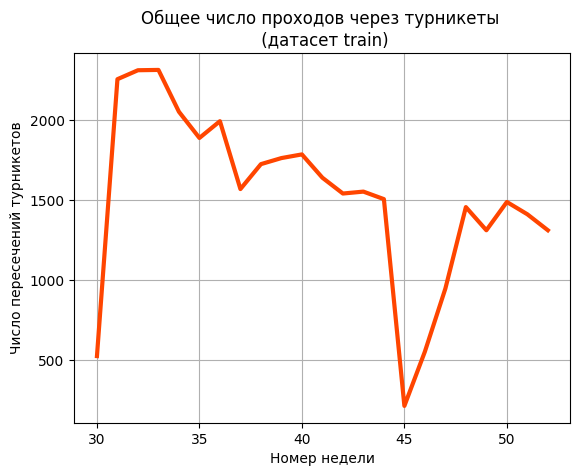

In [48]:
# визуализируем распределение общего числа проходов
# через пропускные пункты по неделям
train['week_number'].value_counts().sort_index().plot(
    grid = True,
    color = 'orangered',
    linewidth = 3)
plt.title('Общее число проходов через турникеты \n (датасет train)')
plt.xlabel('Номер недели')
plt.ylabel('Число пересечений турникетов')
plt.show()

Мы видим сравнительно небольшое число проходов через контрольные точки в 30-ю и особенно 45-ю неделю. Посмотрим, как распределилось число проходов по дням каждой из этих недель.

In [49]:
train.loc[train['week_number'] == 30]['weekday'].value_counts().sort_index()

4    474
5     18
6     32
Name: weekday, dtype: int64

In [50]:
# выведем уникальные значения номеров дней 30-й недели
train.loc[train['week_number'] == 30]['day'].unique()

array([29, 30, 31])

In [51]:
# выведем даты начала и конца 30-й недели
print(
    train.loc[train['week_number'] == 30]['ts'].min(),
    train.loc[train['week_number'] == 30]['ts'].max()
)

2022-07-29 09:08:54 2022-07-31 20:29:21


Как было указано выше, самая ранняя дата наблюдений датасета train 29 июля 2022. То есть 'первая' (30-я с начала календарного года) неделя включает сведения только о трех днях. Однако сюда въодят пятница и два выходных дня, в которые число посещений организации прогнозируемо ниже, что подтверждают данные среза. Удалять эту неделю с тремя днями не требуется, т.к. структура посещений предположительно будет соответствовать среднестатистической.

Сделаем аналогичный срез по 45-й неделе датасета train.

In [52]:
train.loc[train['week_number'] == 45]['weekday'].value_counts().sort_index()

0    159
4     35
6     18
Name: weekday, dtype: int64

In [53]:
# выведем уникальные значения номеров дней 45-й недели
train.loc[train['week_number'] == 45]['day'].unique()

array([ 7, 11, 13])

In [54]:
# выведем даты начала и конца 45-й недели
print(
    train.loc[train['week_number'] == 45]['ts'].min(),
    train.loc[train['week_number'] == 45]['ts'].max()
)

2022-11-07 07:11:12 2022-11-13 23:28:42


На 45-й неделе проход в организацию осуществлялся только три дня из семи: в понедельник 7 ноября 2022 зафиксировано 159 пересечений пунктов пропуска, в пятницу 11 ноября 2022 - 35, в воскресенье 13 ноября 2022 - 18. Эта неделя значительно отличается от остальных недель, поэтому все наблюдения для 45-й недели удалим из датасета train.

In [55]:
# проверим тип данных столбцов датасета train
train.dtypes

user_id                 int64
ts             datetime64[ns]
gate_id                 int64
day                     int64
weekday                 int64
hour                    int64
minute                  int64
week_number            UInt32
dtype: object

In [56]:
# изменим тип данных признака 'week_number' на int
train = train.astype({'week_number': 'Int64'})

In [57]:
# проверим изменение типа данных
train.dtypes

user_id                 int64
ts             datetime64[ns]
gate_id                 int64
day                     int64
weekday                 int64
hour                    int64
minute                  int64
week_number             Int64
dtype: object

In [58]:
# выведем размер датасета train до удаления наблюдений по 45-й неделе
train.shape

(35135, 8)

In [59]:
# удаляем наблюдения из датасета train
train = train.query('week_number != 45', engine='python')

In [60]:
# выведем размер датасета train после удаления наблюдений
train.shape

(34923, 8)

Проведем аналогичный анализ распределения количества пересечений турникетов по неделям из датасета test.

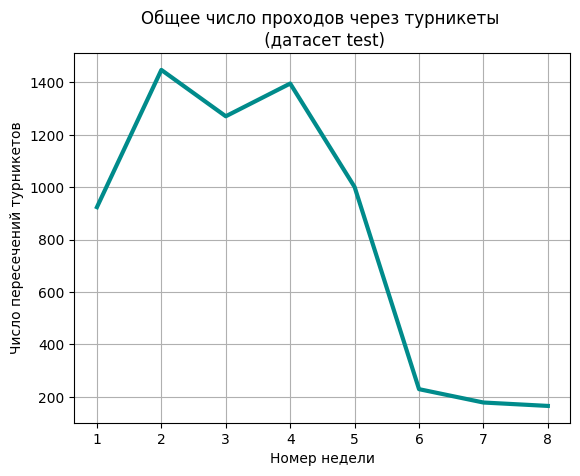

In [61]:
# визуализируем распределение общего числа проходов
# через пропускные пункты по неделям
test['week_number'].value_counts().sort_index().plot(
    grid = True,
    color = 'darkcyan',
    linewidth = 3)
plt.title('Общее число проходов через турникеты \n (датасет test)')
plt.xlabel('Номер недели')
plt.ylabel('Число пересечений турникетов')
plt.show()

Значения недель 6, 7 и 8 слишком сильно отличаются от значений недель с 1-й по 5-ю. Количество посещений организации в январе-феврале 2023 г. примерно в два раза ниже, чем в проанализированные  месяцы 2022 года. Однако в недели с 6-й по 8-ю оно находится на критически низком уровне. Оставлять для машинного обучения совершенно не типичные значения недель 6, 7 и 8-й нецелесообразно: в этот период либо значительно изменился поток посетителей, либо вовсе произошел технический сбой фиксирующего оборудовнаия, и мы имеем в распоряжении сильно искаженную картину посещения турникетов.

Удалим из датасета test все наблюдения, относящиеся к 6-й, 7-й и 8-й неделям.

In [62]:
# выведем размер датасета test до удаления наблюдений по 6, 7, 8-й неделям
test.shape

(6612, 8)

In [63]:
# создаем список недель, наблюдения по которым должны быть удалены
weeks_del = [6, 7, 8]

In [64]:
# удаляем наблюдения, соответствующие номерам недель из списка weeks_del
for number in weeks_del:
    test = test.query(f'week_number != {number}', engine='python')

In [65]:
# выведем размер датасета test после удаления наблюдений
test.shape

(6040, 8)

Признак 'ts' далее не понадобится, его можно удалить из обоих датасетов.

In [66]:
# удаляем признак 'ts'
train = train.drop(columns = 'ts')
test = test.drop(columns = 'ts')

Признак 'week_number' также далее не понадобится, так как его значения в датасетах train и test не пересекаются. Удалим его.

In [67]:
# удаляем признак 'week_number'
train = train.drop(columns = 'week_number')
test = test.drop(columns = 'week_number')

In [68]:
# выведем первые две строки датасета train
train.head(2)

,user_id,gate_id,day,weekday,hour,minute
0,18,7,29,4,9,8
1,18,9,29,4,9,9


In [69]:
# выведем первые две строки датасета test
test.head(2)

,gate_id,user_word,day,weekday,hour,minute
37518,9,gini,3,1,8,21
37520,5,gini,3,1,8,21


На основе признака **'hour'** создадим еще ряд бинарных признаков.

In [70]:
# выведем все уникальные значения признака 'hour'
np.sort(train['hour'].unique())

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23])

In [71]:
np.sort(test['hour'].unique())

array([ 0,  1,  3,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23])

С учетом того, что в датасете train нет пересечений контрольных пунктов в 0, 1 и 3 часа (ночные часы), а в датасете test нет времени пересечения пункта пропуска в 6 часов утра, сформируем следующие бинарные признаки:

* 'night' (с 22 часов ночи до 3 часов утра)

* 'morning' (c 6 часов утра до 11 часов дня)

* 'time_day' (с 12 часов до 17 часов)

* 'evening' (с 18 до 21 часа)

In [72]:
# для каждого времени дня создадим список часов
night = [0, 1, 3, 22, 23]
morning = [6, 7, 8, 9, 10, 11]
time_day = [12, 13, 14, 15, 16, 17]
evening = [18, 19, 20, 21]

In [73]:
# создаем список с компонентами дня
day_hours = [night, morning, time_day, evening]

# создаем список названий признаков
day_hours_name = ['night', 'morning', 'time_day', 'evening']

In [74]:
# создаем новые признаки

number = 0

for i in day_hours:
    # создаем функцию для признака
    def new_column(row):
        if row in i:
            return 1
        else:
            return 0

    # создаем признак в датасете train
    train[day_hours_name[number]] = \
        train['hour'].progress_apply(new_column)

    # создаем признак в датасете test
    test[day_hours_name[number]] = \
        test['hour'].progress_apply(new_column)

    number += 1

  0%|          | 0/34923 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/34923 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/34923 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/34923 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

In [75]:
# для проверки выведем 7 наугад выбранных строк датасета train
train.sample(7)

,user_id,gate_id,day,weekday,hour,minute,night,morning,time_day,evening
13038,15,5,7,2,11,19,0,1,0,0
8711,37,3,23,1,19,25,0,0,0,1
21315,31,4,7,4,16,45,0,0,1,0
5688,18,5,15,0,14,3,0,0,1,0
23130,50,11,14,4,17,16,0,0,1,0
13012,39,5,7,2,11,11,0,1,0,0
34423,12,11,16,4,16,5,0,0,1,0


In [76]:
# сумма значений по каждому из четырех новых признаков
# должна быть равна 1
temp = pd.DataFrame()

temp['sum'] = train[day_hours_name].sum(axis = 1)
print(temp.sum(axis = 0) / train.shape[0])

del temp

sum    1.0
dtype: float64


In [77]:
# для проверки выведем 7 наугад выбранных строк датасета test
test.sample(7)

,gate_id,user_word,day,weekday,hour,minute,night,morning,time_day,evening
41451,5,predict,23,0,11,25,0,1,0,0
42537,6,collinear,26,3,20,36,0,0,0,1
39154,4,distributed,11,2,13,48,0,0,1,0
40410,3,matrix,18,2,11,14,0,1,0,0
41730,4,binary,24,1,11,53,0,1,0,0
40732,10,ridge,19,3,10,8,0,1,0,0
42501,13,f1,26,3,19,49,0,0,0,1


Дополнительные бинарные признаки можно создать на основе признаков 'day', 'weekday', 'hour' и 'gate_id'.

Начнем с признака **'day'**.

In [78]:
# выведем уникальные значения дней из датасетов train и test
print('Уникальные значения дней в датасете train:',
      np.sort(train['day'].unique()))
print()
print('Уникальные значения дней в датасете test:',
      np.sort(test['day'].unique()))

Уникальные значения дней в датасете train: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]

Уникальные значения дней в датасете test: [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31]


In [79]:
# выведем число уникальных значений дней из датасетов train и test
train['day'].nunique(), test['day'].nunique()

(31, 30)

В датасете test отсутствуют наблюдения для дня каждого месяца под номером 8.

Создадим единый список с номерами дней, т.к. набор обучающих признаков для train и test должен быть одинаковым.

В матрице с обучающими признаками датасета test окажется один из признаков, включающий только нулевые значения. После завершения процедуры создания новых обучающих признаков все такие признаки, заполненные только нулевыми значениями, будут удалены.

In [80]:
# создаем список уникальных значений дней
day_list = list(np.sort(train['day'].unique()))
day_list = [int(x) for x in day_list]
type(day_list[2])

int

In [81]:
# создаем новые признаки

for i in range(len(day_list)):
    # создаем функцию для признака
    def new_column(row):
        if day_list[i] == row:
            return 1
        else:
            return 0

    # создаем признак в датасете train
    train['day_' + str(i + 1)] = \
        train['day'].apply(new_column)

    # создаем признак в датасете test
    test['day_' + str(i + 1)] = \
        test['day'].apply(new_column)

In [82]:
# выведем названия столбцов датасета train
train.columns

Index(['user_id', 'gate_id', 'day', 'weekday', 'hour', 'minute', 'night',
       'morning', 'time_day', 'evening', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11',
       'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18',
       'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25',
       'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31'],
      dtype='object')

In [83]:
# изменим тип всех значений списка day_list на str
day_list = ['day_' + str(x) for x in day_list]
type(day_list[2])

str

In [84]:
# сумма значений по каждому из серии новых признаков
# должна быть равна 1
temp = pd.DataFrame()

temp['sum'] = train[day_list].sum(axis = 1)
print(temp.sum(axis = 0) / train.shape[0])

del temp

temp = pd.DataFrame()

temp['sum'] = test[day_list].sum(axis = 1)
print(temp.sum(axis = 0) / test.shape[0])

del temp

sum    1.0
dtype: float64
sum    1.0
dtype: float64


Следующая серия признаков будет создана на основе признака **'weekday'** - по одному бинарному признаку для каждого дня недели.

In [85]:
# выведем уникальные значения дней недели в датасете train
list_weekday = np.sort(train['weekday'].unique())
list_weekday = [int(x) for x in list_weekday]
list_weekday

[0, 1, 2, 3, 4, 5, 6]

0 соответствует понедельнику, 6 - воскресенью, в чем не трудно убедиться, выполнив подсчет по каждому дню недели.

In [86]:
# подсчитаем количество пересечений контрольных пунктов
# по дням недели по датасету train
train['weekday'].value_counts().sort_index()

0    6705
1    6218
2    6720
3    7144
4    7345
5     574
6     217
Name: weekday, dtype: int64

In [87]:
# дополнительно выведем уникальыне значения дней недели датасета test
test['weekday'].value_counts().sort_index()

0     754
1    1303
2    1296
3    1158
4    1366
5     101
6      62
Name: weekday, dtype: int64

В обоих датасетах фигурируют одни и те же дни недели, поэтому для создания признаков можно использовать созданный на основе датасета train список list_weekday.

In [88]:
# создаем новые признаки

for i in range(len(list_weekday)):
    # создаем функцию для признака
    def new_column(row):
        if list_weekday[i] == row:
            return 1
        else:
            return 0

    # создаем признак в датасете train
    train['weekday_' + str(i)] = \
        train['weekday'].apply(new_column)

    # создаем признак в датасете test
    test['weekday_' + str(i)] = \
        test['weekday'].apply(new_column)

In [89]:
# выведем названия столбцов датасета train
train.columns

Index(['user_id', 'gate_id', 'day', 'weekday', 'hour', 'minute', 'night',
       'morning', 'time_day', 'evening', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11',
       'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18',
       'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25',
       'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6'],
      dtype='object')

In [90]:
# изменим тип всех значений списка list_weekday на str
list_weekday = ['weekday_' + str(x) for x in list_weekday]
type(list_weekday[2])

str

In [91]:
# сумма значений по каждому из серии новых признаков
# должна быть равна 1
temp = pd.DataFrame()

temp['sum'] = train[list_weekday].sum(axis = 1)
print(temp.sum(axis = 0) / train.shape[0])

del temp

temp = pd.DataFrame()

temp['sum'] = test[list_weekday].sum(axis = 1)
print(temp.sum(axis = 0) / test.shape[0])

del temp

sum    1.0
dtype: float64
sum    1.0
dtype: float64


Еще одна серия признаков будет создана на основе признака **'hour'** - по одному бинарному признаку для каждого часа.

In [92]:
# выведем уникальные значения признака 'hour' в датасете train
list_hours_train = np.sort(train['hour'].unique())
list_hours_train = [int(x) for x in list_hours_train]
list_hours_train

[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

In [93]:
# выведем уникальные значения признака 'hour' в датасете test
list_hours_test = np.sort(test['hour'].unique())
list_hours_test = [int(x) for x in list_hours_test]
list_hours_test

[0, 1, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

Ранее уже было установлено, что набор уникальных значений номеров часов в датасетах train и test различается. Есть риск, что появление различающихся групп признаков приведет к конфликту при запуске машинного обучения. Поэтому создадим новый список, который будет включать все общие и уникальные значения из двух списокв.

In [94]:
# создаем единый список значений часов
common_list_hours = list(set(list_hours_train + list_hours_test))
common_list_hours = [int(x) for x in common_list_hours]
common_list_hours

[0, 1, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

In [95]:
# создаем новые признаки

for i in range(len(common_list_hours)):
    # создаем функцию для признака
    def new_column(row):
        if common_list_hours[i] == row:
            return 1
        else:
            return 0

    # создаем признак в датасете train
    train['hour_' + str(common_list_hours[i])] = \
        train['hour'].apply(new_column)

    # создаем признак в датасете test
    test['hour_' + str(common_list_hours[i])] = \
        test['hour'].apply(new_column)

In [96]:
# выведем названия столбцов датасета train
train.columns

Index(['user_id', 'gate_id', 'day', 'weekday', 'hour', 'minute', 'night',
       'morning', 'time_day', 'evening', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11',
       'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18',
       'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25',
       'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'hour_0', 'hour_1', 'hour_3', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

In [97]:
len(test.columns) == len(train.columns)

True

In [98]:
# изменим тип всех значений списка common_list_hours на str
common_list_hours = ['hour_' + str(x) for x in common_list_hours]
type(common_list_hours[2])

str

In [99]:
# выведем значения часов, которые есть в test, но нет в train
set(list_hours_test) - set(list_hours_train)

{0, 1, 3}

In [100]:
# выведем значения часов, которые есть в test, но нет в train
set(list_hours_train) - set(list_hours_test)

{6}

In [101]:
# сумма значений по каждому из серии новых признаков
# должна быть равна 1
temp = pd.DataFrame()

temp['sum'] = train[common_list_hours].sum(axis = 1)
print(temp.sum(axis = 0) / train.shape[0])

del temp

temp = pd.DataFrame()

temp['sum'] = test[common_list_hours].sum(axis = 1)
print(temp.sum(axis = 0) / test.shape[0])

del temp

sum    1.0
dtype: float64
sum    1.0
dtype: float64


Следующая серия признаков будет создана на основе признака **'gate_id'**. Уникальные gate_id различается в датасетах train и test, поэтому выведем  значения gate_id обоих датасетов и создадим единый список.

In [102]:
# выведем уникальные значения gate_id из датасета train
gate_id_train = list(np.sort(train['gate_id'].unique()))
gate_id_train

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15]

In [103]:
# выведем уникальные значения gate_id из датасета test
gate_id_test = list(np.sort(test['gate_id'].unique()))
gate_id_test

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15]

In [104]:
# создадим список, включающий все уникальные gate_id
# из датасетов train и test
common_gate_list = list(set(gate_id_train + gate_id_test))
common_gate_list = [int(x) for x in common_gate_list]
print(common_gate_list)
print(type(common_gate_list[5]))

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15]
<class 'int'>


In [105]:
# создаем новые признаки

for i in range(len(common_gate_list)):
    # создаем функцию для признака
    def new_column(row):
        if common_gate_list[i] == row:
            return 1
        else:
            return 0

    # создаем признак в датасете train
    train['gate_id_' + str(common_gate_list[i])] = \
        train['gate_id'].apply(new_column)

    # создаем признак в датасете test
    test['gate_id_' + str(common_gate_list[i])] = \
        test['gate_id'].apply(new_column)

In [106]:
# выведем названия столбцов датасета train
train.columns

Index(['user_id', 'gate_id', 'day', 'weekday', 'hour', 'minute', 'night',
       'morning', 'time_day', 'evening', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11',
       'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18',
       'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25',
       'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'hour_0', 'hour_1', 'hour_3', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23', 'gate_id_3', 'gate_id_4', 'gate_id_5',
       'gate_id_6', 'gate_id_7', 'gate_id_8', 'gate_id_9', 'gate_id_10',
       'gate_id_11', 'gate_id_12', 'gate_id_13', 'gate_id_15'],
      dtype='object')

In [107]:
len(test.columns) == len(train.columns)

True

In [108]:
# изменим тип всех значений списка common_gate_list на str
common_gate_list = ['gate_id_' + str(x) for x in common_gate_list]
type(common_gate_list[2])

str

Для проверки новых признаков удалять признаки для несовпадающих значений gate_id из датасетов train и test не требуется, так как они заполнены только нулями.

In [109]:
# сумма значений по каждому из серии новых признаков
# должна быть равна 1
temp = pd.DataFrame()

temp['sum'] = train[common_gate_list].sum(axis = 1)
print(temp.sum(axis = 0) / train.shape[0])

del temp

temp = pd.DataFrame()

temp['sum'] = test[common_gate_list].sum(axis = 1)
print(temp.sum(axis = 0) / test.shape[0])

del temp

sum    1.0
dtype: float64
sum    1.0
dtype: float64


На основе признака **weekday** создадим два бинарных признака: день может быть рабочим, день может быть выходным.

In [110]:
# для каждого типа дня недели создадим соответствующий список
working_days = [0, 1, 2, 3, 4]
weekends = [5, 6]

In [111]:
# создаем список с типами дней недели
week_days = [working_days, weekends]

# создаем список названий признаков
week_days_name = ['working_days', 'weekends']

In [112]:
# создаем новые признаки

number = 0

for i in week_days:
    # создаем функцию для признака
    def new_column(row):
        if row in i:
            return 1
        else:
            return 0

    # создаем признак в датасете train
    train[week_days_name[number]] = \
        train['weekday'].progress_apply(new_column)

    # создаем признак в датасете test
    test[week_days_name[number]] = \
        test['weekday'].progress_apply(new_column)

    number += 1

  0%|          | 0/34923 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/34923 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

In [113]:
# сумма значений по каждому из двух новых признаков
# должна быть равна 1
temp = pd.DataFrame()

temp['sum'] = train[week_days_name].sum(axis = 1)
print(temp.sum(axis = 0) / train.shape[0])

del temp

temp = pd.DataFrame()

temp['sum'] = test[week_days_name].sum(axis = 1)
print(temp.sum(axis = 0) / test.shape[0])

del temp

sum    1.0
dtype: float64
sum    1.0
dtype: float64


На основе признака **'minute'** создадим еще ряд бинарных признаков.

In [114]:
# проверим, совпадает ли количество уникальных значений минут
# в датасетазх train и test
train['minute'].nunique() == test['minute'].nunique()

True

Cформируем следующие бинарные признаки:

* 'first_quarter' (с 0-й до 14-й минуты)

* 'second_quarter' (c 15-й до 29-й минуты)

* 'third_quarter' (с 30-й до 44-й минуты)

* 'fourth_quarter' (с 45-й до 59-й минуты)

In [115]:
# для каждого периода создадим список значений минут
first_quarter = list(range(0, 15))
second_quarter = list(range(15, 30))
third_quarter = list(range(30, 45))
fourth_quarter = list(range(45, 60))

In [116]:
# создаем список с четырьмя четвертями часа (с учетом минут)
hour_minutes = [
    first_quarter, second_quarter,
    third_quarter, fourth_quarter
]

# создаем список названий признаков
hour_minutes_names = [
    'first_quarter', 'second_quarter',
    'third_quarter', 'fourth_quarter'
]

In [117]:
# создаем новые признаки

number = 0

for i in hour_minutes:
    # создаем функцию для признака
    def new_column(row):
        if row in i:
            return 1
        else:
            return 0

    # создаем признак в датасете train
    train[hour_minutes_names[number]] = \
        train['minute'].progress_apply(new_column)

    # создаем признак в датасете test
    test[hour_minutes_names[number]] = \
        test['minute'].progress_apply(new_column)

    number += 1

  0%|          | 0/34923 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/34923 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/34923 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/34923 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

In [118]:
# выведем названия столбцов датасета train
train.columns

Index(['user_id', 'gate_id', 'day', 'weekday', 'hour', 'minute', 'night',
       'morning', 'time_day', 'evening', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11',
       'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18',
       'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25',
       'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'hour_0', 'hour_1', 'hour_3', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23', 'gate_id_3', 'gate_id_4', 'gate_id_5',
       'gate_id_6', 'gate_id_7', 'gate_id_8', 'gate_id_9', 'gate_id_10',
       'gate_id_11', 'gate_id_12', 'gate_id_13', 'gate_id_15', 'working_days',
       'weekend

In [119]:
# проверим, совпадает ли число признаков в датасетах train и test
len(test.columns) == len(train.columns)

True

In [120]:
# сумма значений по каждому из серии новых признаков
# должна быть равна 1
temp = pd.DataFrame()

temp['sum'] = train[hour_minutes_names].sum(axis = 1)
print(temp.sum(axis = 0) / train.shape[0])

del temp

temp = pd.DataFrame()

temp['sum'] = test[hour_minutes_names].sum(axis = 1)
print(temp.sum(axis = 0) / test.shape[0])

del temp

sum    1.0
dtype: float64
sum    1.0
dtype: float64


При обучении линейных моделей нулевой вектор коллинеарен любому другому вектору. Это препятсвует получению качественных результатов обучения линейных моделей. При создании новых признаков могли появиться признаки, заполненные только нулевыми значениями. Выявим, есть ли такие в датасетах train и test.

In [121]:
temp_train = pd.DataFrame(train.sum(), columns = ['sum_total'])
temp_train.loc[temp_train['sum_total'] == 0]

,sum_total
hour_0,0
hour_1,0
hour_3,0


In [122]:
temp_test = pd.DataFrame(test.sum(), columns = ['sum_total'])
temp_test.loc[temp_test['sum_total'] == 0]

,sum_total
day_8,0
hour_6,0


Выявленные признаки необходимо удалить из обоих датасетов - train и test. Таким образом будет обеспечен единый набор признаков.

In [123]:
# создадим список из названий признаков на удаление
columns_to_del = (
    list(temp_train.loc[temp_train['sum_total'] == 0].index) +
    list(temp_test.loc[temp_test['sum_total'] == 0].index)
)
columns_to_del

['hour_0', 'hour_1', 'hour_3', 'day_8', 'hour_6']

In [124]:
# выведем размеры датасетов до удаления признаков
train.shape, test.shape

((34923, 87), (6040, 87))

In [125]:
# удаляем лишние признаки из датасетов train и test
train = train.drop(columns_to_del, axis = 1)
test = test.drop(columns_to_del, axis = 1)

In [126]:
# выведем размеры датасетов после удаления признаков
train.shape, test.shape

((34923, 82), (6040, 82))

In [127]:
# удалим ненужные файлы
del temp_train
del temp_test

In [128]:
# сохраним в датафрейм результат проверки датасета train
# на пропуски
temp_train_isna = pd.DataFrame(train.isna().sum(), columns = ['isna_sum'])

# вычислим количество признаков с пропущенными значениями
# в датасете train
temp_train_isna['isna_sum'].sum()

0

In [129]:
# сохраним в датафрейм результат проверки датасета test
# на пропуски
temp_test_isna = pd.DataFrame(test.isna().sum(), columns = ['isna_sum'])

# вычислим количество признаков с пропущенными значениями
# в датасете test
temp_test_isna['isna_sum'].sum()

0

Пропусков нет, поэтому можно переходить к финальному этапу подготовки данных для машинного обучения.

In [130]:
# удалим ненужные файлы
del temp_train_isna
del temp_test_isna

Проведем проверку признаков датасета train на мультиколинеарность.

In [131]:
# проверим признаки датасета train на мультиколинеарность
train.corr().style.background_gradient(cmap = 'magma')

Линейная корреляция, превышающая 0.8 или -0.8 выявлена в четырех случаях:

* между признаками 'hour_22' и 'night' (0.895)

* между признаками 'weekday_5' и 'weekends' (0.849)

* 'weekday_5' и 'working_days' (-0.849)

* 'weekends' и 'working_days' (-1)

Удалим из датасетов train и test признаки 'hour_22', 'weekday_5', 'weekends'.

In [132]:
# создадим список признаков для удаления
columns_to_del = [
    'hour_22',
    'weekday_5',
    'weekends'
]

In [133]:
# выведем размеры датасетов до удаления признаков
train.shape, test.shape

((34923, 82), (6040, 82))

In [134]:
# удаляем лишние признаки из датасетов train и test
train = train.drop(columns = columns_to_del, axis = 1)
test = test.drop(columns = columns_to_del, axis = 1)

In [135]:
# выведем размеры датасетов после удаления признаков
train.shape, test.shape

((34923, 79), (6040, 79))

In [136]:
# из датасета train выделим обучающие признаки
features_train = train.drop(columns = 'user_id')

In [137]:
# из датасета train выделим целевой признак 'user_id'
target = train['user_id']

In [138]:
# выведем размеры датасетов features и target
features_train.shape, target.shape

((34923, 78), (34923,))

In [139]:
# из датасета test выделим обучающие признаки
features_test = test.drop(columns = 'user_word')

In [140]:
# из датасета test выделим зашифрованные имена посетителей
# 'user_word', - датасет будет объединен с результатами предсказаний
user_word = test['user_word']

In [141]:
# выведем размеры датасетов features_test и user_word
features_test.shape, user_word.shape

((6040, 78), (6040,))

## <font color='green'>**3 ПОСТРОЕНИЕ ЛИНЕЙНОЙ МОДЕЛИ МАШИННОГО ОБУЧЕНИЯ**</font>

---

### **3.1 Обучение модели LogisticRegression с помощью Pipeline**

---

In [142]:
# для снижения возможного переобучения модели при кросс-валидации
# для задачи классификации целесообразно добавить стратификацию классов
# для каждого fold
cv = StratifiedKFold(
    n_splits = 5,
    shuffle = True,
    random_state = RANDOM_STATE)

In [143]:
# создадим список столбцов (признаков),
# относящиеся к числовому типу данных
numerical_columns_selector = selector(dtype_exclude = 'category')
numerical_columns = numerical_columns_selector(features_train)
len(numerical_columns)

78

In [144]:
# создалим трансформер для числовых признаков
numeric_transformer =  make_pipeline(MinMaxScaler())

In [145]:
# создадим препроцессор для числовых признаков
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numerical_columns)
        ], remainder='passthrough'
)

In [146]:
# объявляем модель
lr = LogisticRegression(random_state = RANDOM_STATE)

In [147]:
# объявляем объект конвейера
pipe_lr = imb_pipeline([
    ('preprocessor', preprocessor),
    ('polynom', PolynomialFeatures()),
    ('feature_select', SelectKBest(score_func=f_regression)),
    ('lr', lr)
])

In [148]:
# визуализируем пайплайн
pipe_lr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['gate_id', 'day', 'weekday',
                                                   'hour', 'minute', 'night',
                                                   'morning', 'time_day',
                                                   'evening', 'day_1', 'day_2',
                                                   'day_3', 'day_4', 'day_5',
                                                   'day_6', 'day_7', 'day_9',
                                                   'day_10', 'day_11', 'day_12',
                                                   'day_13', 'day_14', 'day_15',
                                                   'day_16', 'day_17', 'day_18',
                                                   'day_19', 'day_20', 'day_21',
                                                   'day_22', ...])])),
                ('polynom', PolynomialFeatures()),
                ('feature_select',
                 SelectKBest(score_func=<function f_regression at 0x7e93624b3010>)),
                ('lr', LogisticRegression(random_state=1))])

In [149]:
# получим список гиперпараметров пайплайна
pd.DataFrame(pipe_lr.get_params().keys())

,0
0,memory
1,steps
2,verbose
3,preprocessor
4,polynom
5,feature_select
6,lr
7,preprocessor__n_jobs
8,preprocessor__remainder
9,preprocessor__sparse_threshold


In [150]:
# создаем словарь с гиперпараметрами для отбора
# лучших гиперпараметров с помощью кроссвалидации
params_lr = {
    'polynom__degree': [1],
    'feature_select__k': [20, 40, 'all'],
    'lr__C': [0.001, 0.01, 0.1, 1],
    'lr__max_iter': [100, 500],
    'lr__multi_class': ['ovr'],
    'lr__penalty': ['l2'],
    'lr__solver': ['lbfgs'],
    'lr__random_state': [RANDOM_STATE],
    'lr__class_weight': ['balanced']
}

In [151]:
# объявляем объект GridSearchCV
grid_lr = GridSearchCV(
    pipe_lr,
    params_lr,
    scoring = 'roc_auc_ovr',
    verbose = 1,
    cv = cv,
    refit = True,
    n_jobs = -1)

In [152]:
# обучаем модель
start = datetime.now()

grid_lr.fit(features_train, target)

lr_time_spent = datetime.now() - start
print('Время обучения модели LogisticRegression:\n', lr_time_spent)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Время обучения модели LogisticRegression:
 0:22:44.149129


In [153]:
# сохраним лучшую модель в переменную
best_lr = grid_lr.best_estimator_
best_lr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['gate_id', 'day', 'weekday',
                                                   'hour', 'minute', 'night',
                                                   'morning', 'time_day',
                                                   'evening', 'day_1', 'day_2',
                                                   'day_3', 'day_4', 'day_5',
                                                   'day_6', 'day_7', 'day_9',
                                                   'day_10', 'day_11', 'day_12',
                                                   'day_13', 'day_14', 'day_15',
                                                   'day_16', 'day_17', 'day_18',
                                                   'day_19', 'day_20', 'day_21',
                                                   'day_22', ...])])),
                ('polynom', PolynomialFeatures(degree=1)),
                ('feature_select',
                 SelectKBest(k=20,
                             score_func=<function f_regression at 0x7e93624b3010>)),
                ('lr',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    multi_class='ovr', random_state=1))])

In [154]:
# выведем на экран гиперпараметры лучшей модели
grid_lr.best_params_

{'feature_select__k': 20,
 'lr__C': 0.001,
 'lr__class_weight': 'balanced',
 'lr__max_iter': 100,
 'lr__multi_class': 'ovr',
 'lr__penalty': 'l2',
 'lr__random_state': 1,
 'lr__solver': 'lbfgs',
 'polynom__degree': 1}

In [155]:
# получим предсказания модели на обучающих признаках
preds_train = best_lr.predict(features_train)

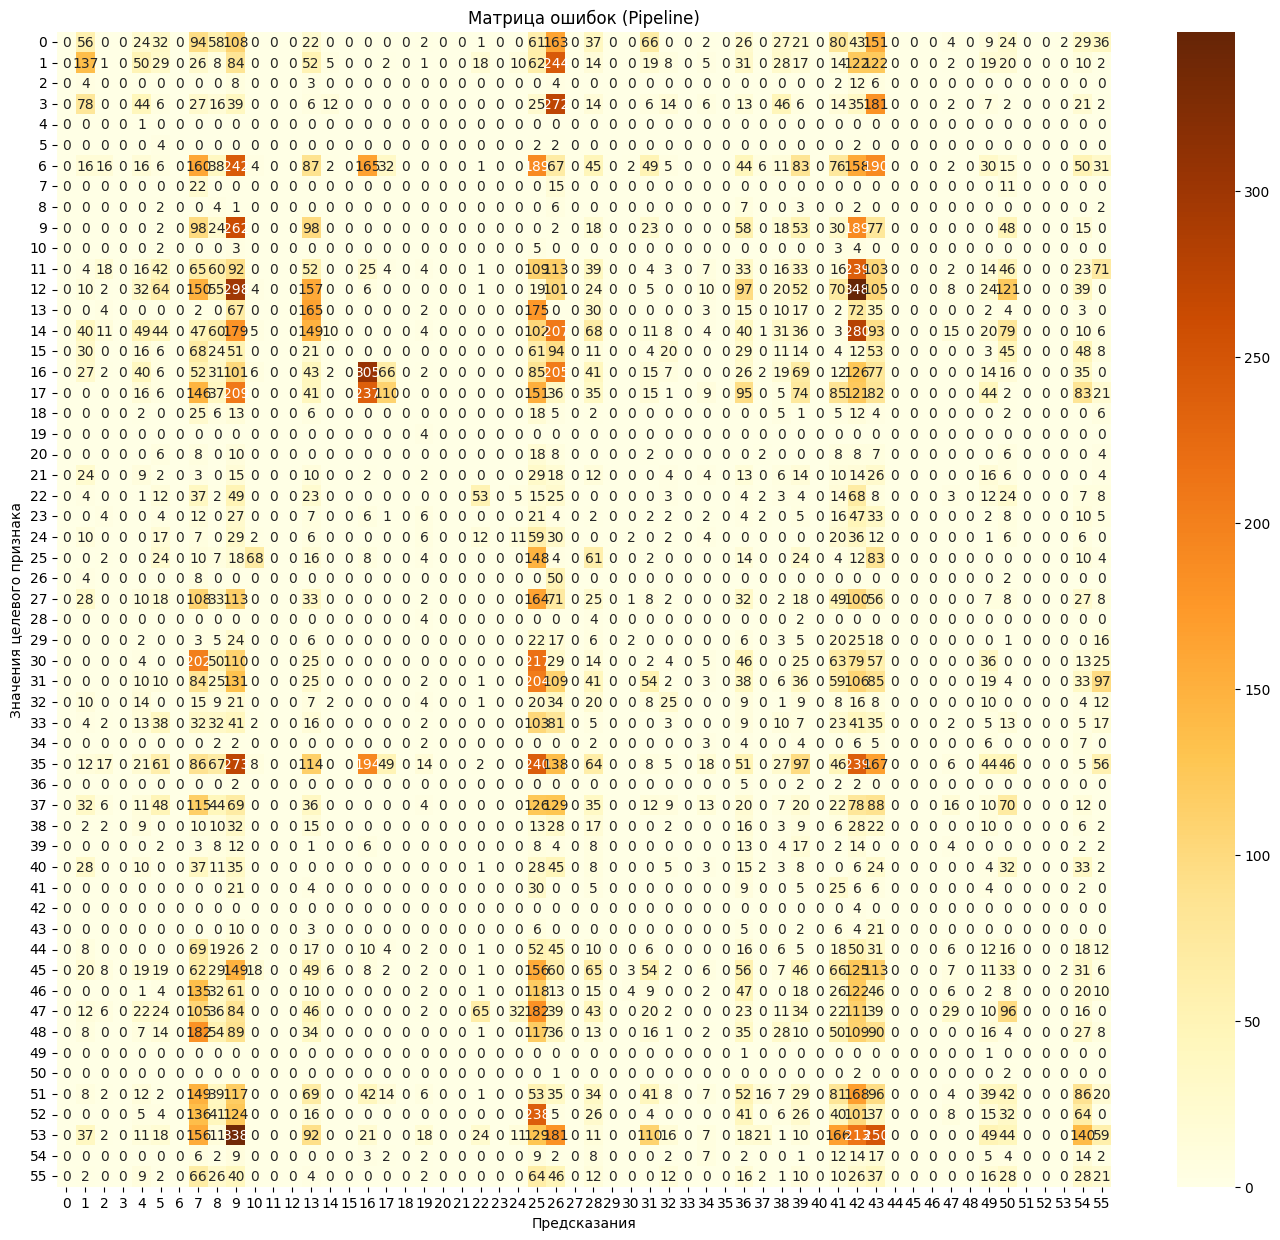

In [156]:
# построим матрицу ошибок
plt.figure(figsize = (17, 15))

confmatrix = confusion_matrix(
        target,
        preds_train)
f = sns.heatmap(confmatrix,
                annot = True,
                cmap = 'YlOrBr',
                fmt = 'g')

f.set_title('Матрица ошибок (Pipeline)')
f.set_xlabel('Предсказания')
f.set_ylabel('Значения целевого признака')
plt.yticks(rotation = 0)
plt.show()

In [157]:
# выведем отчет об итогах обучения
print(classification_report(
    target,
    preds_train
))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1178
           1       0.21      0.12      0.15      1162
           2       0.00      0.00      0.00        39
           3       0.00      0.00      0.00       894
           4       0.00      1.00      0.00         1
           5       0.01      0.40      0.01        10
           6       0.00      0.00      0.00      1838
           7       0.01      0.46      0.02        48
           8       0.00      0.15      0.01        27
           9       0.07      0.26      0.11      1015
          10       0.00      0.00      0.00        17
          11       0.00      0.00      0.00      1254
          12       0.00      0.00      0.00      1822
          14       0.10      0.27      0.15       608
          15       0.26      0.01      0.01      1612
          17       0.00      0.00      0.00       633
          18       0.29      0.21      0.25      1432
          19       0.38    

Визуально оценить качество предсказаний можно с помощью матрицы ошибок. Правильные ответы находятся на главной диагонали (из верхнего левого угла в нижний правый). Все значения, находящиеся вне главной диагонали - ошибочные.

In [158]:
# получаем предсказания модели на тестовых признаках
preds = best_lr.predict(features_test)

### **3.2 Обучение модели LogisticRegression без Pipeline (multi_class='multinomial')**

---

In [159]:
# создаем коппи датасетов
features_train_mn = features_train.copy()
features_test_mn = features_test.copy()

Как было показано выше, данные обучающие и тестовые могут сильно различаться, поэтому обучим и применим скалер отдельно для датасетов train и test.

In [160]:
# создаем объект для масштабирования данных
scaler_mn = MinMaxScaler()

# обучаем и применяем масштабирование данных к датасету train
scaler_mn.fit(features_train_mn)
features_train_mn = scaler_mn.transform(features_train_mn)

In [161]:
# применяем масштабирование данных к датасету test
features_test_mn = scaler_mn.transform(features_test_mn)

In [162]:
# объявляем модель
lm = OneVsRestClassifier(
    LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        random_state = RANDOM_STATE))

In [163]:
# обучаем модель
lm.fit(features_train_mn, target)

OneVsRestClassifier(estimator=LogisticRegression(multi_class='multinomial',
                                                 random_state=1))

In [164]:
# получим предсказания модели на обучающих признаках
preds_train = lm.predict(features_train_mn)

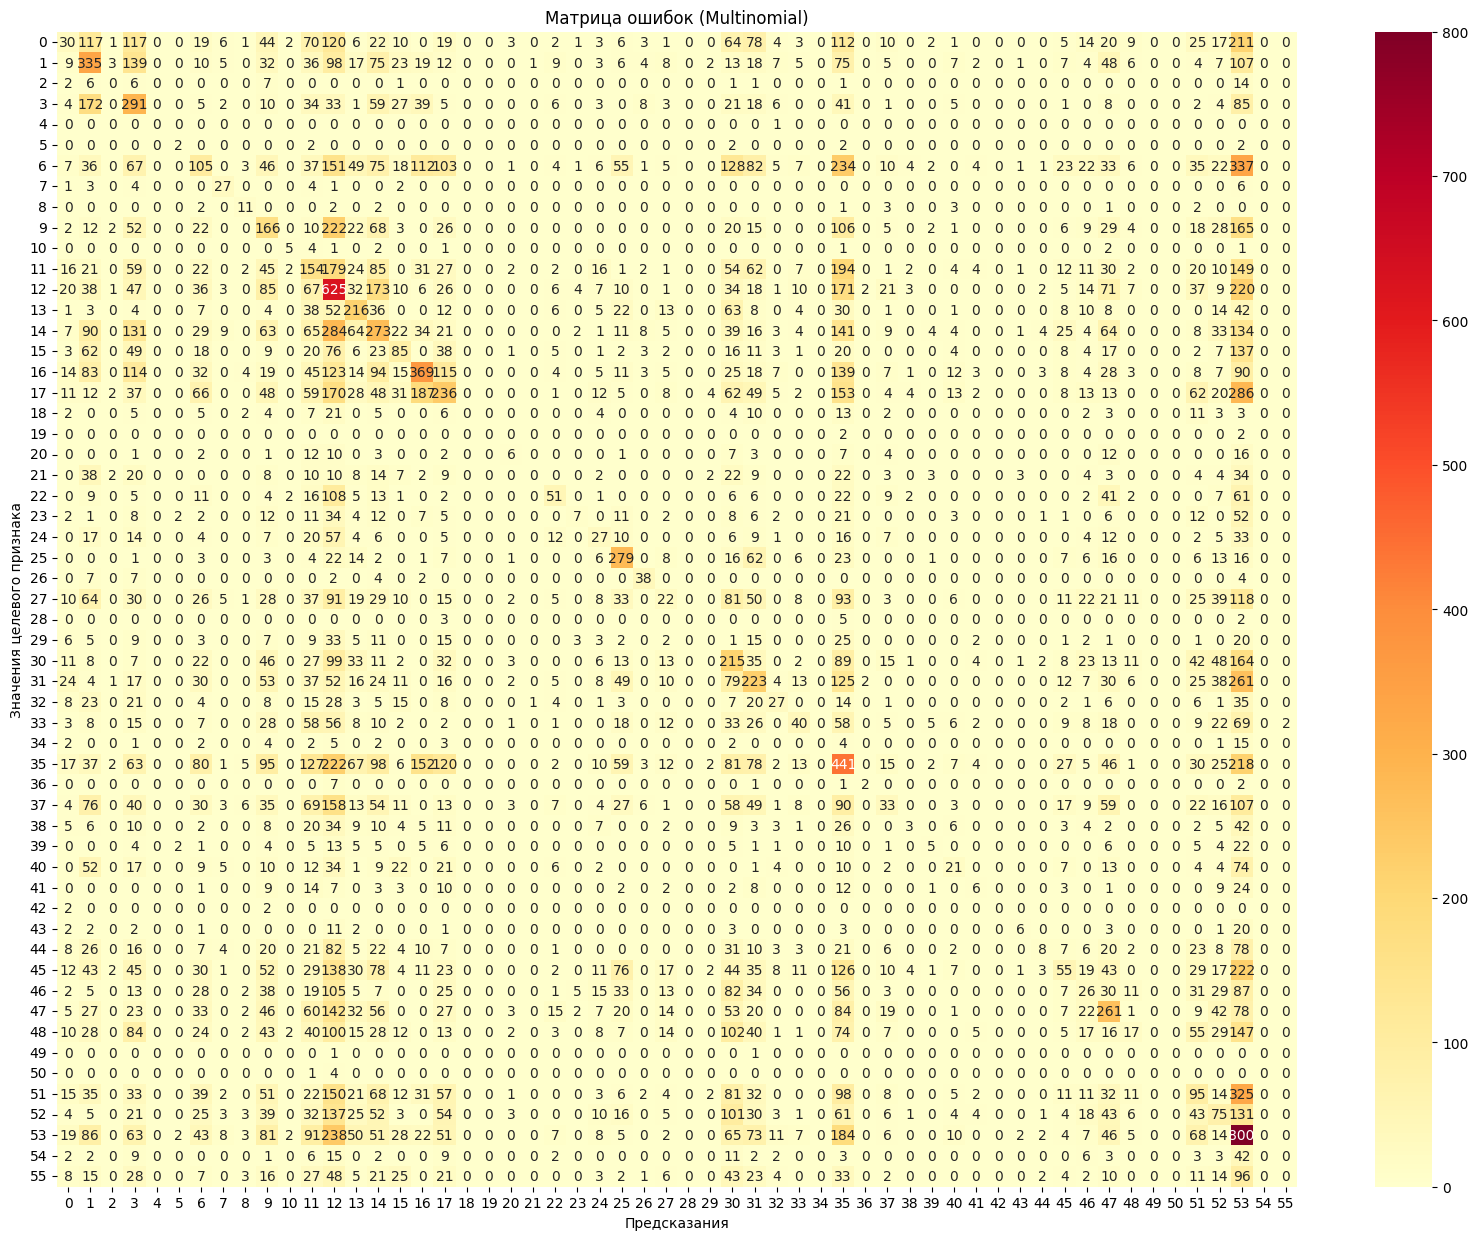

In [165]:
# построим матрицу ошибок
plt.figure(figsize = (20, 15))

confmatrix = confusion_matrix(
        target,
        preds_train)
f = sns.heatmap(confmatrix,
                annot = True,
                cmap = 'YlOrRd',
                fmt = 'g')

f.set_title('Матрица ошибок (Multinomial)')
f.set_xlabel('Предсказания')
f.set_ylabel('Значения целевого признака')
plt.yticks(rotation = 0)
plt.show()

In [166]:
# выведем отчет об итогах обучения
print(classification_report(
    target,
    preds_train
))

              precision    recall  f1-score   support

           0       0.10      0.03      0.04      1178
           1       0.21      0.29      0.24      1162
           2       0.00      0.00      0.00        39
           3       0.17      0.33      0.22       894
           4       0.00      0.00      0.00         1
           5       0.25      0.20      0.22        10
           6       0.12      0.06      0.08      1838
           7       0.32      0.56      0.41        48
           8       0.22      0.41      0.29        27
           9       0.12      0.16      0.14      1015
          10       0.33      0.29      0.31        17
          11       0.10      0.12      0.11      1254
          12       0.14      0.34      0.20      1822
          14       0.24      0.36      0.29       608
          15       0.16      0.17      0.16      1612
          17       0.20      0.13      0.16       633
          18       0.35      0.26      0.30      1432
          19       0.19    

In [167]:
preds = lm.predict(features_test_mn)

### **3.3 Обучение модели LogisticRegression без Pipeline (multi_class='ovr')**

---

In [168]:
# создаем коппи датасетов
features_train_ovr = features_train.copy()
features_test_ovr = features_test.copy()

Как было показано выше, данные обучающие и тестовые могут сильно различаться, поэтому обучим и применим скалер отдельно для датасетов train и test.

In [169]:
# создаем объект для масштабирования данных
scaler_ovr = MinMaxScaler()

# обучаем и применяем масштабирование данных к датасету train
scaler_ovr.fit(features_train_ovr)
features_train_ovr = scaler_ovr.transform(features_train_ovr)

In [170]:
# применяем масштабирование данных к датасету test
features_test_ovr = scaler_ovr.transform(features_test_ovr)

In [171]:
# объявляем модель
lm = OneVsRestClassifier(
    LogisticRegression(
        multi_class='ovr',
        solver='lbfgs',
        random_state = RANDOM_STATE))

In [172]:
# обучаем модель
lm.fit(features_train_ovr, target)

OneVsRestClassifier(estimator=LogisticRegression(multi_class='ovr',
                                                 random_state=1))

In [173]:
# получим предсказания модели на обучающих признаках
preds_train = lm.predict(features_train_ovr)

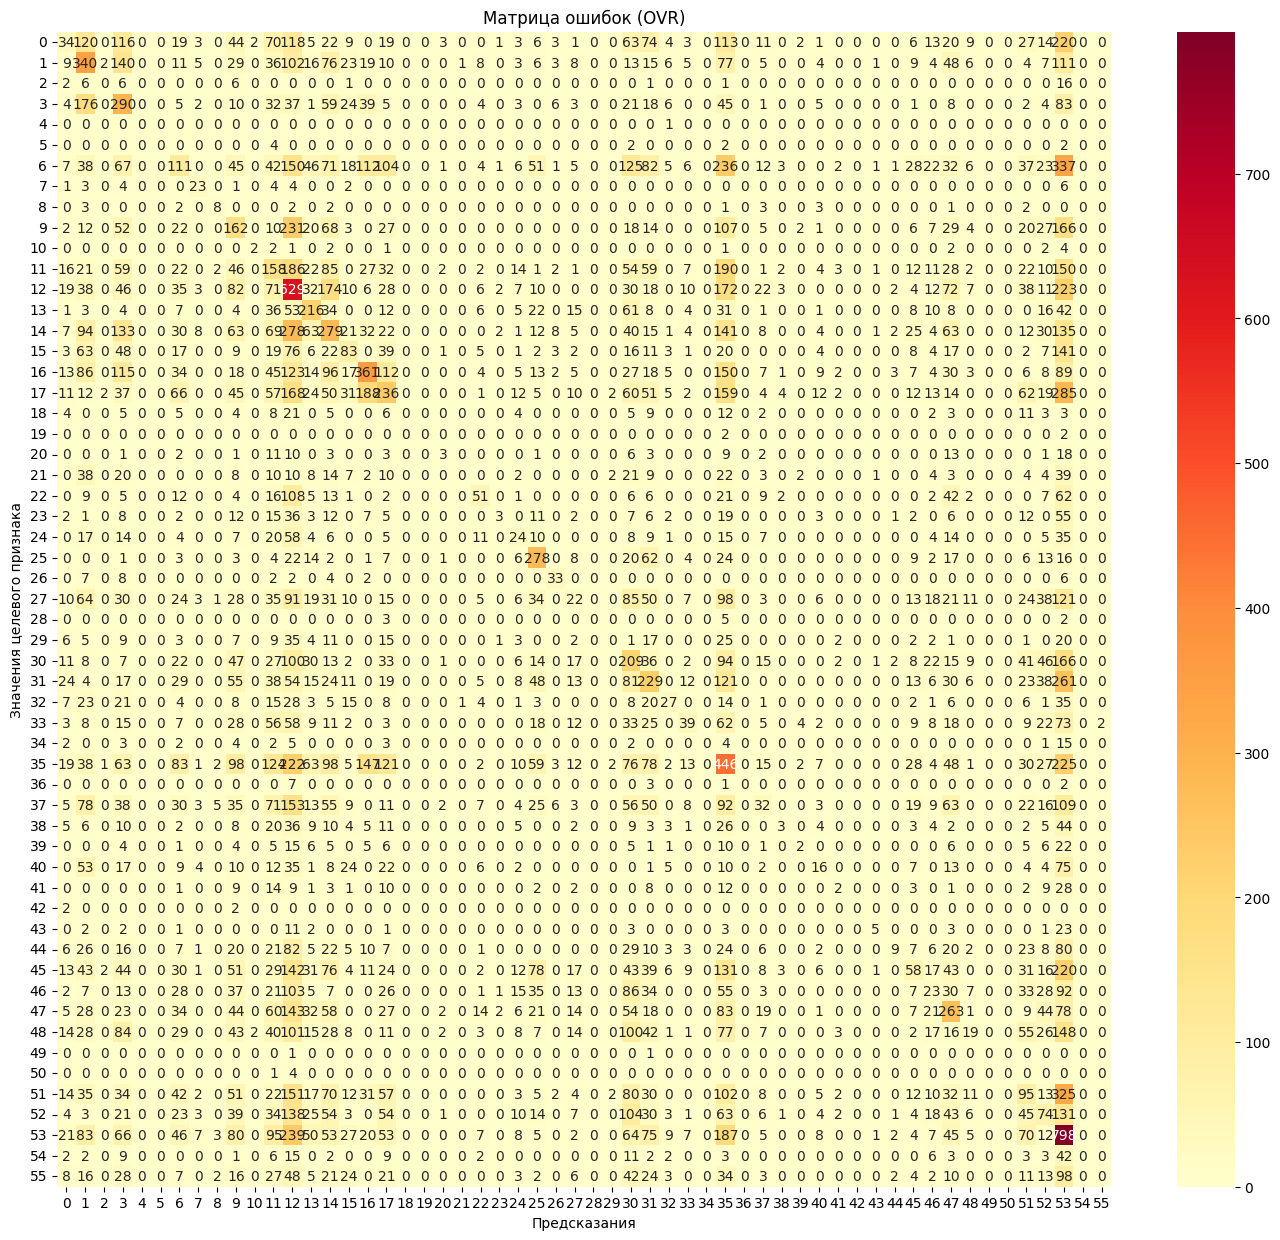

In [174]:
# построим матрицу ошибок
plt.figure(figsize = (17, 15))

confmatrix = confusion_matrix(
        target,
        preds_train)
f = sns.heatmap(confmatrix,
                annot = True,
                cmap = 'YlOrRd',
                fmt = 'g')

f.set_title('Матрица ошибок (OVR)')
f.set_xlabel('Предсказания')
f.set_ylabel('Значения целевого признака')
plt.yticks(rotation = 0)
plt.show()

In [175]:
# выведем отчет об итогах обучения
print(classification_report(
    target,
    preds_train
))

              precision    recall  f1-score   support

           0       0.11      0.03      0.05      1178
           1       0.21      0.29      0.24      1162
           2       0.00      0.00      0.00        39
           3       0.17      0.32      0.22       894
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00        10
           6       0.13      0.06      0.08      1838
           7       0.33      0.48      0.39        48
           8       0.35      0.30      0.32        27
           9       0.12      0.16      0.14      1015
          10       0.33      0.12      0.17        17
          11       0.10      0.13      0.11      1254
          12       0.14      0.35      0.20      1822
          14       0.25      0.36      0.29       608
          15       0.16      0.17      0.17      1612
          17       0.20      0.13      0.16       633
          18       0.35      0.25      0.29      1432
          19       0.19    

In [176]:
# получим предсказания модели на тестовых обучающих признаках
preds = lm.predict(features_test_ovr)

Для промежуточного контроля полученных результатов сформируем submit-файл на основе предсказаний модели Logistic Regression без Pipeline (multi_class = 'ovr').

In [177]:
# объединим зашифрованные имена посетителей и предсказания модели
submit = pd.DataFrame()

submit['user_word'] = user_word
submit['preds'] = preds

In [178]:
# выведем первые пять строк датасета submit
submit.head()

,user_word,preds
37518,gini,18
37520,gini,18
37521,gini,18
37522,gini,18
37523,epsilon,1


Ранее было установлено, что в датасете train содержится информация о 56 уникальных посетителях, тогда как в датасете test - только о 34. Сделаем предположение, что для посетителей, сведения о которых есть и в датасете train, и в датасете test, модель чаще определяла правильно user_id. "Правильность" в этом случае будет определяться тем, что верный user_id был угадан чаще и резко выделяется на фоне других значений при группировке. Если посетителя из датасета train нет в датасете test, тогда модель будет наугад выбирать разные варианты, и явного лидера не будет просматриваться. Такие случаи должны быть заполнены значением -999.

Выберем пять разных user_word с разной частотой встречаемости.


In [179]:
# выведем уникальные user_word и частоту встречаемости в датасете test
# каждого посетителя

user_word_frequency = pd.DataFrame(
    data = submit['user_word'].value_counts(ascending = False)
)
user_word_frequency.columns = ['quantity']
user_word_frequency

,quantity
f1,633
loss,447
sigmoid,390
binary,329
epsilon,303
x,277
significant,268
collinear,252
independent,234
residual,224


In [180]:
# создадим список 'user_word',
# у которых 50 и менее пересечений контрольных пунктов
less_than_51 = [
    user_word_frequency.index.values[i]
    for i in range(len(user_word_frequency['quantity']))
    if user_word_frequency['quantity'][i] < 51
]

In [181]:
# выведем полученные значения 'user_word'
less_than_51.sort()
less_than_51

['aucroc', 'blue', 'lasso', 'logistic', 'precision', 'regression', 'y']

In [182]:
# выведем предсказанные моделью уникальные user_id
submit['preds'].unique()

array([18,  1, 15, 34,  0, 37, 40, 12,  8, 49, 50, 54, 33,  9, 19, 27, 32,
        3, 17, 11, 53,  6, 48, 14, 47, 55, 42, 39, 35, 24, 26, 29, 46, 25,
       43, 22, 28, 36, 45])

In [183]:
# выведем количество уникальных user_id,
# содержащихся в предсказании модели
submit['preds'].nunique()

39

Сделаем предположение, что система могла ошибиться в детекции посетителя из тестовой выборки test, если такого посетителя не было в обучающей выборке train. Соответственно, Для всех 'user_word', у которых зафиксировано 50 и менее пересечений пунктов пропуска, выставим значение '-999'.

In [184]:
# итоговые предсказания получим на основе самого частотного 'user_id'
# для соответствующего 'user_word'
submit_file = pd.DataFrame(
    submit.groupby('user_word')['preds'].agg(
        lambda x: x.value_counts().index[0])
    )

In [185]:
# заменяем на -999 предскзаания для 'user_word',
# у которых 50 и менее пересечений контрольных пунктов в датасете test
submit_file['new_preds'] = [
    -999 if submit_file.index.values[i] in less_than_51
    else submit_file['preds'][i]
    for i in range(len(submit_file['preds']))
]

In [186]:
# удаляем столбец preds
submit_file = submit_file.drop(columns = ['preds'])

# меняем название столбца 'new_preds' на 'preds'
submit_file.columns = ['preds']

In [187]:
# выведем предсказанные результаты
submit_file

,preds
user_word,
aucroc,-999
binary,12
blue,-999
categorical,14
coefficient,1
collinear,12
distributed,55
epsilon,1
f1,18


In [188]:
# выведем количество уникальных user_id в submit_file
submit_file['preds'].nunique()

11

In [189]:
# сохраним предсказанные результаты в csv-файл
submit_file.to_csv('submit_file.csv')

In [190]:
# извлечем из облачного хранилища данные для проверки
data = pd.read_csv('/content/submit_file.csv')

In [191]:
# выведем данные, предназначенные для submit
data

,user_word,preds
0,aucroc,-999
1,binary,12
2,blue,-999
3,categorical,14
4,coefficient,1
5,collinear,12
6,distributed,55
7,epsilon,1
8,f1,18
9,fit,1


## <font color='green'>**4 ПОСТРОЕНИЕ МОДЕЛИ МАШИННОГО ОБУЧЕНИЯ, ОСНОВАННОЙ НА РЕШАЮЩИХ ДЕРЕВЬЯХ**</font>

---

Для получаения предсказаний с помощью модели машинного обучения, основанной на решающих деревьях, применим CatBoost.

In [192]:
# объявляем модель
catboost = CatBoostClassifier(
    random_state = RANDOM_STATE,
    logging_level = 'Silent',
    loss_function = 'MultiClassOneVsAll'
)

In [193]:
# объявляем объект конвейера
pipe_catboost = imb_pipeline([
    ('feature_select', SelectKBest(score_func = chi2)),
    ('catboost', catboost)
])

In [194]:
# визуализируем пайплайн
pipe_catboost

Pipeline(steps=[('feature_select',
                 SelectKBest(score_func=<function chi2 at 0x7e93624b2ef0>)),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x7e932cc224d0>)])

In [195]:
# получим список гиперпараметров пайплайна
pd.DataFrame(pipe_catboost.get_params().keys())

,0
0,memory
1,steps
2,verbose
3,feature_select
4,catboost
5,feature_select__k
6,feature_select__score_func
7,catboost__loss_function
8,catboost__logging_level
9,catboost__random_state


In [196]:
# создаем словарь с гиперпараметрами для отбора
# лучших гиперпараметров с помощью кроссвалидации
params_catboost = {
    'feature_select__k': [60],
    #'catboost__learning_rate': [0.0001, 0.001, 0.01, 0.1]
}

In [197]:
# объявляем объект RandomizedSearchCV
grid_catboost = RandomizedSearchCV(
    pipe_catboost,
    params_catboost,
    n_iter = 10,
    scoring = 'roc_auc',
    verbose = 1,
    cv = cv,
    refit = True,
    random_state = RANDOM_STATE,
    n_jobs = -1)

In [198]:
# обучаем модель
start = datetime.now()

grid_catboost.fit(features_train, target)

catboost_time_spent = datetime.now() - start
print('Время обучения модели CatBoostClassifier:\n',
      catboost_time_spent)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Время обучения модели CatBoostClassifier:
 0:33:19.063238


In [199]:
# сохраним лучшую модель в переменную
best_catboost = grid_catboost.best_estimator_
best_catboost

Pipeline(steps=[('feature_select',
                 SelectKBest(k=60,
                             score_func=<function chi2 at 0x7e93624b2ef0>)),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x7e932cc23ee0>)])

In [200]:
# выведем на экран гиперпараметры лучшей модели
grid_catboost.best_params_

{'feature_select__k': 60}

In [201]:
# получим предсказания модели на обучающих признаках
preds_train = best_catboost.predict(features_train)

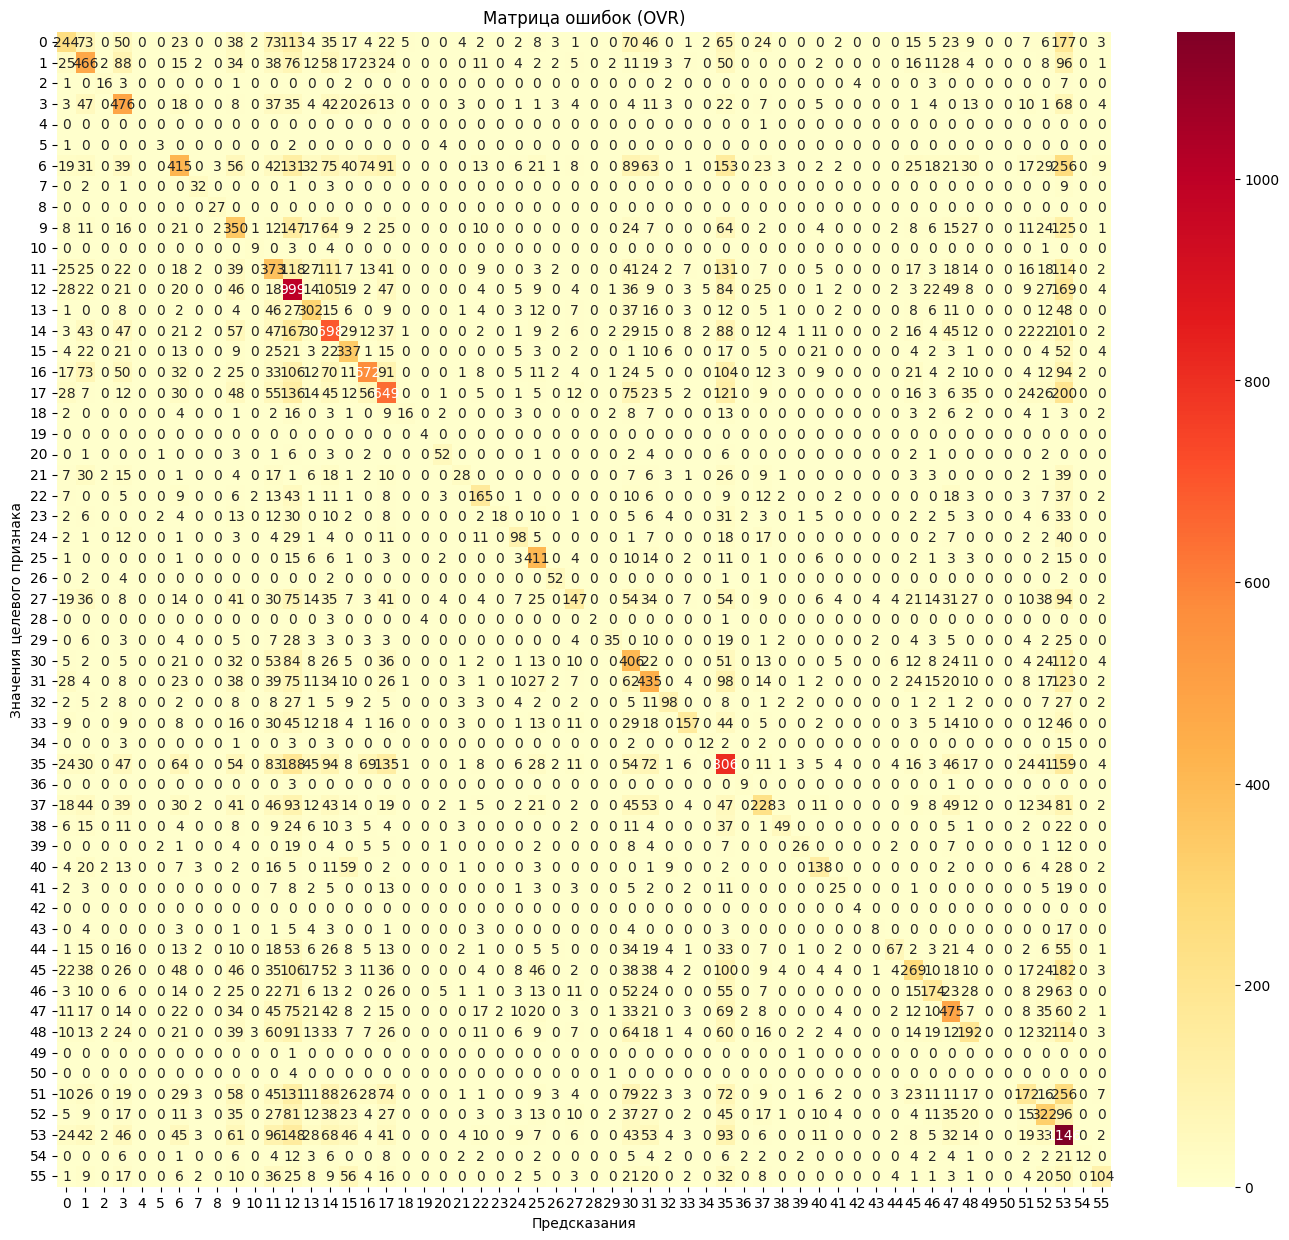

In [202]:
# построим матрицу ошибок
plt.figure(figsize = (17, 15))

confmatrix = confusion_matrix(
        target,
        preds_train)
f = sns.heatmap(confmatrix,
                annot = True,
                cmap = 'YlOrRd',
                fmt = 'g')

f.set_title('Матрица ошибок (OVR)')
f.set_xlabel('Предсказания')
f.set_ylabel('Значения целевого признака')
plt.yticks(rotation = 0)
plt.show()

In [203]:
# выведем отчет об итогах обучения
print(classification_report(
    target,
    preds_train
))

              precision    recall  f1-score   support

           0       0.39      0.21      0.27      1178
           1       0.39      0.40      0.39      1162
           2       0.57      0.41      0.48        39
           3       0.39      0.53      0.45       894
           4       0.00      0.00      0.00         1
           5       0.38      0.30      0.33        10
           6       0.40      0.23      0.29      1838
           7       0.57      0.67      0.62        48
           8       0.75      1.00      0.86        27
           9       0.27      0.34      0.30      1015
          10       0.53      0.53      0.53        17
          11       0.24      0.30      0.26      1254
          12       0.27      0.55      0.36      1822
          14       0.41      0.50      0.45       608
          15       0.34      0.43      0.38      1612
          17       0.41      0.53      0.46       633
          18       0.61      0.40      0.48      1432
          19       0.38    

In [204]:
# получим предсказания модели на тестовых обучающих признаках
preds = best_catboost.predict(features_test)

In [205]:
# объединим зашифрованные имена посетителей и предсказания модели
submit = pd.DataFrame()

submit['user_word'] = user_word
submit['preds'] = preds

In [206]:
# выведем первые пять строк датасета submit
submit.head()

,user_word,preds
37518,gini,3
37520,gini,3
37521,gini,3
37522,gini,3
37523,epsilon,1


In [207]:
# выведем предсказанные моделью уникальные user_id
np.sort(submit['preds'].unique())

array([ 0,  1,  3,  6,  7,  8,  9, 11, 12, 14, 15, 17, 18, 19, 22, 24, 26,
       27, 28, 29, 32, 33, 34, 35, 37, 39, 40, 42, 43, 46, 47, 48, 49, 50,
       53, 54, 55, 57])

In [208]:
# выведем количество уникальных user_id,
# содержащихся в предсказании модели
submit['preds'].nunique()

38

In [209]:
# итоговые предсказания получим на основе самого частотного 'user_id'
# для соответствующего 'user_word'
submit_file = pd.DataFrame(
    submit.groupby('user_word')['preds'].agg(
        lambda x: x.value_counts().index[0])
    )

In [210]:
# выведем предсказанные результаты
submit_file

,preds
user_word,
aucroc,49
binary,12
blue,55
categorical,14
coefficient,15
collinear,12
distributed,11
epsilon,12
f1,19


In [211]:
# выведем количество уникальных user_id в submit_file
submit_file['preds'].nunique()

15

In [212]:
# сохраним предсказанные результаты в csv-файл
submit_file.to_csv('submit_file.csv')

In [213]:
# извлечем из облачного хранилища данные для проверки
data = pd.read_csv('/content/submit_file.csv')

In [214]:
# выведем данные, предназначенные для submit
data

,user_word,preds
0,aucroc,49
1,binary,12
2,blue,55
3,categorical,14
4,coefficient,15
5,collinear,12
6,distributed,11
7,epsilon,12
8,f1,19
9,fit,1


# **<font color='crimson'>ОТЧЕТ ПО ПРОЕКТУ «Турникеты»</font>**

---

**(1)** Сведения о пересечении посетителями контрольных пунктов представлены в датасете в хронологическом порядке.

**(2)** Исследование количества проходов через турникеты по неделям по датасету **train** позволило выявить сравнительно небольшое число проходов в 30-ю и особенно 45-ю недели.


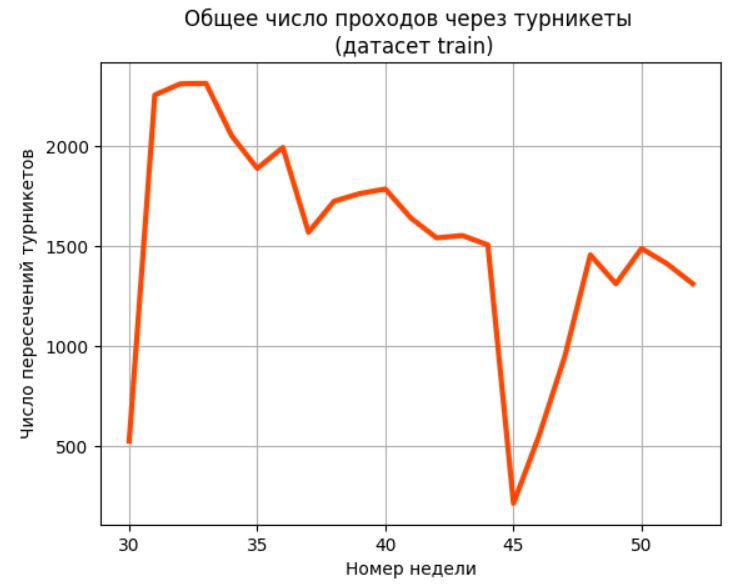

Самая ранняя дата наблюдений датасета train 29 июля 2022. То есть 'первый' (30-й с начала календарного года) месяц включает сведения только о трех днях. Однако он включает пятницу и два выходных дня, в которые число посещений организации прогнозируемо ниже, что подтверждают данные среза. Удалять эту неделю с тремя днями не требуется, т.к. структура посещений предположительно соответствует среднестатистической.

На 45-й неделе проход в организацию осуществлялся только три дня из семи: в понедельник 7 ноября 2022 зафиксировано 159 пересечений пунктов пропуска, в пятницу 11 ноября 2022 - 35, в воскресенье 13 ноября 2022 - 18. Эта неделя значительно отличается от остальных недель, поэтому все наблюдения для 45-й недели были удалены из датасета train.

**(3)** Проведен аналогичный анализ количества проходов через турникеты по датасету **test**.

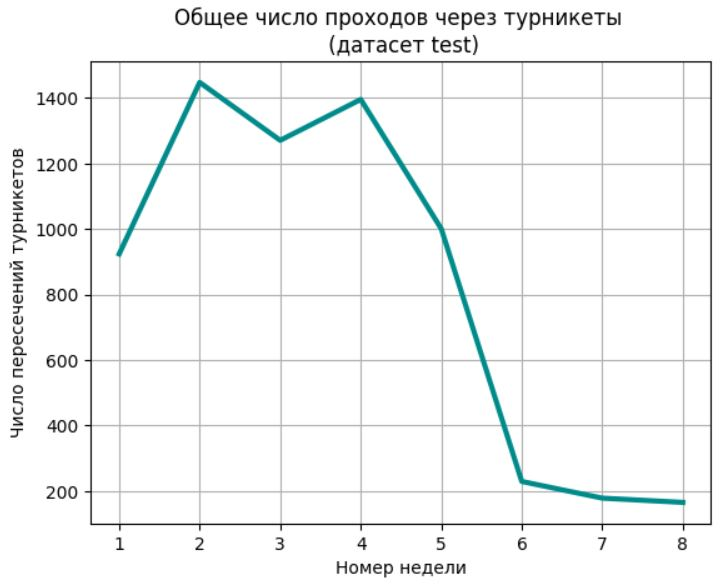

Количество посещений организации в 6-ю, 7-ю и 8-ю недели находится на очень низком уровне и резко контрастирует с другими неделями. Указанные недели были удалены, их значения не использовались для машинного обучения.

**(4)** На основе признака ‘ts’, имеющего тип ‘datetime64’, с помощью Feature Engineering создано 80 признаков для обучения машинных моделей. Проведен анализ признаков на мультиколинеарность, в результате которого удалено 3 признака.

**(5)** Модель LogisticRegression обучена с помощью Pipleline и без Pipeline c multi_class = ‘multinomial’ и ‘ovr’. Модели, обученные без Pipeline с multi_class = ‘multinomial’ и ‘ovr’ показали более высокий результат в сравнении с моделью, обученной с помощью Pipeline. Результат обучения указанных двух моделей оказался примерно одинаков.

**(6)** В качестве модели, основанной на решающих деревьях, была выбрана модель CatBoost, обученная с помощью Pipeline. Лучший результат показал запуск с loss_function = 'MultiClassOneVsAll', который был отправлен как итоговое решение.